## Within-species comparative method

This notebook provides an example implementation of the within-species contrasts method described by Felsenstein (2002) to utilize a migration matrix to control for non-independence among data points when comparing multiple populations from within a species. I implement a transformation to a data set under the same parameters used in the example from his 2002 book chapter.  

The Python code below simulates the data and applies the method. The details of the code are not of great importance, one can hopefully get a feel for what is going on from the text alone.

In [1]:
## import scientific packages
import numpy as np
from numpy import linalg as LA
import pandas as pd

## plotting package
import matplotlib.pyplot as plt
## for embedding plots
%matplotlib inline

--------------  
## Simulated data  

We are interested in teasing apart whether trait similarities among populations are due to parallel adaptations to similar selection pressures, or if they are due to gene-flow. In this example we look at 20 populations that are connected by low levels of migration in a stepping-stone pattern, meaning only adjacent populations exchange genes. The populations are experiencing identical environments, and thus have identical expected mean phenotypes. However, they are still subject to drift, and it is possible that drift and gene flow together can give the appearance of a phenotypic cline. In this case, any cline observed is "false", in the sense that it is not due to selection from the environment. I apply the contrasts method to correct for relatedness (connectedness) of populations and show how this makes the cline disappear. 

First we will create a migration matrix:

In [2]:
## A function to return a linear migration matrix with rate m
def stepping_stone(N,m):
    arr = np.zeros([N,N])
    for i in xrange(1,N-1):
        arr[i,i] = 1.-(2*m)
        arr[i+1,i] = arr[i-1,i] = m
    arr[1,0] = arr[N-2,N-1] = m
    arr[0,0] = arr[N-1,N-1] = 1.-m
    return pd.DataFrame(arr)

In [3]:
## show an example migration matrix for 6 populations with m=0.1
print '\nlinear stepping stone migration matrix\n'
print stepping_stone(6,0.1)


linear stepping stone migration matrix

     0    1    2    3    4    5
0  0.9  0.1  0.0  0.0  0.0  0.0
1  0.1  0.8  0.1  0.0  0.0  0.0
2  0.0  0.1  0.8  0.1  0.0  0.0
3  0.0  0.0  0.1  0.8  0.1  0.0
4  0.0  0.0  0.0  0.1  0.8  0.1
5  0.0  0.0  0.0  0.0  0.1  0.9

[6 rows x 6 columns]


-----------------------  

## Phenotypic data
We will model the evolution of a quantitative character using an additive quantitative genetic model from Lande (?). Here changes in the mean phenotype from one generation to the next change as a function of selection towards local phenotypic optima but balanced against migration with neighboring populations that potentially limit the ability for a population to reach its local optimum. There is also an influence of drift by Brownian motion.

$$   x^{(t+1)} = \sigma\mathbf{p} + (1-\sigma)\mathbf{M}^{t} + \epsilon $$


In [10]:
## A function to simulate trait values given 
## selection (sigma), migration (M), drift (beta/N),
## local optima (P) and pop sizes (D).
def simX(sigma,M,beta,P,D,seed):
    np.random.seed(seed)
    X = np.array([1.]*len(M))
    for i in xrange(10000):
        p1 = sigma*P
        p2 = (1.-sigma)*np.dot(M,X) 
        p3 = [np.random.normal(0., np.sqrt(beta/D[i,i])) \
              for i in xrange(len(X))]
        X = p1+p2+p3
    return X

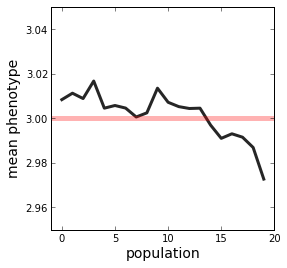

In [11]:
## parameters used by Felsenstein in example
m = 0.1                    ## migration rate
beta = 0.01                ## drift param
sigma = 0.01               ## selection param
M = stepping_stone(20,m)   ## migration matrix
P = np.array([3.]*len(M))  ## identical local optima
D = np.diag([1000]*len(M)) ## equal pop sizes

## simulate trait data
X = simX(sigma, M, beta, P, D, 55555)

## plot trait values across pops
f,ax = plt.subplots(1, figsize=(4,4))
ax.plot(X, lw=3, color="#262626")
ax.set_xlabel("population", fontsize=14)
ax.set_ylabel("mean phenotype", fontsize=14)
ax.axhline(y=3, lw=5, color='red', alpha=.3)
ax.set_ylim(2.95,3.05) 
ax.set_xlim(-1,20) 
f.show()

In this example migration “mimics a cline formed by selection”. Below I transform the phenotypes to make them independent (given our known migration matrix), by finding the eigen decomposition of the migration matrix as described in Felsenstein (2002).

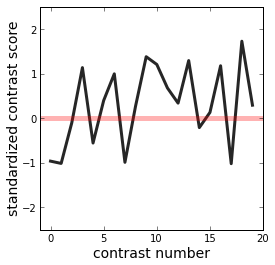

In [12]:
## spectral decomposition of M
I = np.eye(len(D))   ## identity matrix
H = np.dot(np.sqrt(D), np.dot(M, LA.inv(np.sqrt(D))))
alpha = 0.1          ## fudge-factor alpha
G = (H-I)*(1./alpha) ## relative rates of migration
L,U = LA.eigh(G)     ## eigenvalues & -vectors
L = np.diag(L)       ## make eigenvalues a diagonal matrix

## optima (P) are all the same (3), a linear function of T
T = [3.]*20   ## vector of environmental variable (here constant)
a = 0.        ## intercept
b = 1.        ## slope
P = [a + b*t for t in T]   ## opeima as linear function (a+bT)

## function for transformation
## uses population sizes and eigenvectors
def transform(X,D,U):
    return np.dot(LA.inv(np.dot(LA.inv(np.sqrt(D)),U)),X)

## transform phenotypes X make the values in the resulting vector
## z independent
ones = [1.]*20             ## vector of 1s
v = transform(ones,D,U)    ## transform 1s
w = transform(T,D,U)       ## transform environment
z = transform(X,D,U)       ## transform phenotypes

## expectations of the phenotypes
Ez = [(sigma*(a*v[i] + b*w[i])) / (1.-((1.-sigma)*(1+L[i,i]))) \
     for i in range(len(D))]

## variance of phenotypes
Vz = [beta / ( (1. - ((1.-sigma)**2)*((1.+alpha*L[i,i])**2)) ) \
       for i in range(len(D))]

## standardized contrasts
contrasts = [((i-j)/np.sqrt(k)) for (i,j,k) in zip(z,Ez,Vz)]

## plot standardized contrasts across pops
f,ax = plt.subplots(1, figsize=(4,4))
ax.plot(contrasts, lw=3, color="#262626")
ax.set_xlabel("contrast number", fontsize=14)
ax.set_ylabel("standardized contrast score", fontsize=14)
ax.axhline(y=0, lw=5, color='red', alpha=.3)
ax.set_ylim(-2.5,2.5) 
ax.set_xlim(-1,20) 
f.show()

You can see that the values no longer show the false cline created by migration, and that they deviate within 2 SD of the mean expectation of 0. 

## How do I figure out the true value of alpha?
Now I repeat the transformation but this time setting alpha to 100 instead of 0.1. The result is identical.

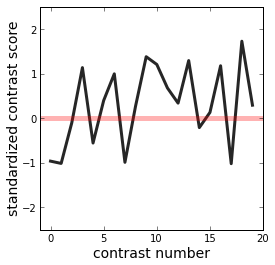

In [13]:
## spectral decomposition of M
alpha = 2000.        ## fudge-factor alpha ************
D = np.diag([1000.]*len(M))
H = np.dot(np.sqrt(D), np.dot(M, LA.inv(np.sqrt(D))))
G = (H-I)*(1./alpha) ## relative rates of migration
L,U = LA.eigh(G)     ## eigenvalues & -vectors
L = np.diag(L)       ## make eigenvalues a diagonal matrix

## optima are all the same (3), a linear function of T
T = [3.]*20   ## vector of environmental variable (here constant)
a = 0.
b = 1.
P = [a + b*t for t in T]

## function for transformation
## uses population sizes and eigenvectors
def transform(X,D,U):
    return np.dot(LA.inv(np.dot(LA.inv(np.sqrt(D)),U)),X)

## transform phenotypes x make the values in the resulting vector z independent
ones = [1.]*20             ## vector of 1s
v = transform(ones,D,U)    ## transform 1s
w = transform(T,D,U)       ## transform environment
z = transform(X,D,U)       ## transform phenotypes

## expectations of the phenotypes
Ez = [(sigma*(a*v[i] + b*w[i])) / (1.-((1.-sigma)*(1+L[i,i]))) \
     for i in range(len(D))]

## variance of phenotypes
Vz = [beta / ( (1. - ((1.-sigma)**2)*((1.+alpha*L[i,i])**2)) ) \
       for i in range(len(D))]

## standardized contrasts
contrasts = [((i-j)/np.sqrt(k)) for (i,j,k) in zip(z,Ez,Vz)]

## plot standardized contrasts across pops
f,ax = plt.subplots(1, figsize=(4,4))
ax.plot(contrasts, lw=3, color="#262626")
ax.set_xlabel("contrast number", fontsize=14)
ax.set_ylabel("standardized contrast score", fontsize=14)
ax.axhline(y=0, lw=5, color='red', alpha=.3)
ax.set_ylim(-2.5,2.5) 
ax.set_xlim(-1,20) 
f.show()

#### I see that alpha does have an effect if populations sizes are not equal, though:  

Here I change population sizes from constant 1000 to a range from 100-2000 increasing by 100 each.

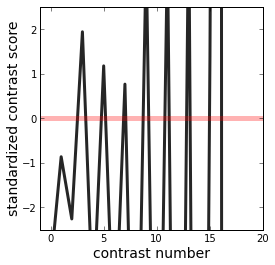

In [14]:
## spectral decomposition of M
alpha = 0.1          ## fudge-factor alpha
D = np.diag([100*i for i in range(1,len(M)+1)])  ## UNequal pop sizes *********
H = np.dot(np.sqrt(D), np.dot(M, LA.inv(np.sqrt(D))))
G = (H-I)*(1./alpha) ## relative rates of migration
L,U = LA.eigh(G)     ## eigenvalues & -vectors
L = np.diag(L)       ## make eigenvalues a diagonal matrix

## optima are all the same (3), a linear function of T
T = [3.]*20   ## vector of environmental variable (here constant)
a = 0.
b = 1.
P = [a + b*t for t in T]

## function for transformation
## uses population sizes and eigenvectors
def transform(X,D,U):
    return np.dot(LA.inv(np.dot(LA.inv(np.sqrt(D)),U)),X)

## transform phenotypes x make the values in the resulting vector z independent
ones = [1.]*20             ## vector of 1s
v = transform(ones,D,U)    ## transform 1s
w = transform(T,D,U)       ## transform environment
z = transform(X,D,U)       ## transform phenotypes

## expectations of the phenotypes
Ez = [(sigma*(a*v[i] + b*w[i])) / (1.-((1.-sigma)*(1+L[i,i]))) \
     for i in range(len(D))]

## variance of phenotypes
Vz = [beta / ( (1. - ((1.-sigma)**2)*((1.+alpha*L[i,i])**2)) ) \
       for i in range(len(D))]

## standardized contrasts
contrasts = [((i-j)/np.sqrt(k)) for (i,j,k) in zip(z,Ez,Vz)]

## plot standardized contrasts across pops
f,ax = plt.subplots(1, figsize=(4,4))
ax.plot(contrasts, lw=3, color="#262626")
ax.set_xlabel("contrast number", fontsize=14)
ax.set_ylabel("standardized contrast score", fontsize=14)
ax.axhline(y=0, lw=5, color='red', alpha=.3)
ax.set_ylim(-2.5,2.5) 
ax.set_xlim(-1,20) 
f.show()

#### If I set alpha much higher I recover reasonable contrast scores again, but the scores do not look identical to before. How do I know what the correct alpha value is?  

Here I increase alpha from 0.1 to 1000.

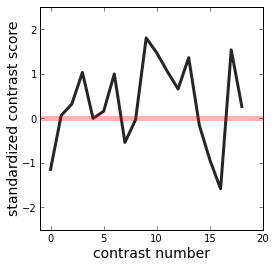

In [15]:
## spectral decomposition of M
alpha = 1000.          ## fudge-factor alpha
D = np.diag([100*i for i in range(1,len(M)+1)])  ## UNequal pop sizes *********
H = np.dot(np.sqrt(D), np.dot(M, LA.inv(np.sqrt(D))))
G = (H-I)*(1./alpha) ## relative rates of migration
L,U = LA.eigh(G)     ## eigenvalues & -vectors
L = np.diag(L)       ## make eigenvalues a diagonal matrix

## optima are all the same (3), a linear function of T
T = [3.]*20   ## vector of environmental variable (here constant)
a = 0.
b = 1.
P = [a + b*t for t in T]

## function for transformation
## uses population sizes and eigenvectors
def transform(X,D,U):
    return np.dot(LA.inv(np.dot(LA.inv(np.sqrt(D)),U)),X)

## transform phenotypes x make the values in the resulting vector z independent
ones = [1.]*20             ## vector of 1s
v = transform(ones,D,U)    ## transform 1s
w = transform(T,D,U)       ## transform environment
z = transform(X,D,U)       ## transform phenotypes

## expectations of the phenotypes
Ez = [(sigma*(a*v[i] + b*w[i])) / (1.-((1.-sigma)*(1+L[i,i]))) \
     for i in range(len(D))]

## variance of phenotypes
Vz = [beta / ( (1. - ((1.-sigma)**2)*((1.+alpha*L[i,i])**2)) ) \
       for i in range(len(D))]

## standardized contrasts
contrasts = [((i-j)/np.sqrt(k)) for (i,j,k) in zip(z,Ez,Vz)]

## plot standardized contrasts across pops
f,ax = plt.subplots(1, figsize=(4,4))
ax.plot(contrasts, lw=3, color="#262626")
ax.set_xlabel("contrast number", fontsize=14)
ax.set_ylabel("standardized contrast score", fontsize=14)
ax.axhline(y=0, lw=5, color='red', alpha=.3)
ax.set_ylim(-2.5,2.5) 
ax.set_xlim(-1,20) 
f.show()

## Model fitting
Here I will use a Bayesian MCMC method to fit a model to infer the five parameters we wish to estimate.

In [16]:
import pymc as pm

In [17]:
## stochastic uninformative priors
alpha_est = pm.Uniform('alpha_est', 0.001, 1000)  ## fudge
beta_est  = pm.Uniform('beta_est', 0., 100.)      ## drift param
sigma_est = pm.Uniform('sigma_est',0., 1.)        ## selection param
x_est     = pm.Uniform('x_est', -10., 10.)        ## slope 
y_est     = pm.Uniform('y_est', -20., 20.)        ## intercept

## deterministic compartmental model
## returns the Covariance Matrix
@pm.deterministic
def Contrasts(alpha=alpha_est, 
              beta=beta_est,
              sigma=sigma_est,
              a=y_est, 
              b=x_est):
    
    " spectral decomposition of M "
    D = np.diag([100*i for i in range(1,len(M)+1)])  ## UNequal pop sizes *********
    G = (H-I)*(1./alpha) ## relative rates of migration
    L,U = LA.eigh(G)     ## eigenvalues & -vectors
    L = np.diag(L)       ## make eigenvalues a diagonal matrix

    " transform phenotypes x to vector z "
    v = transform([1.]*20,D,U)  ## transform vector of 1s (intercept)
    w = transform(T,D,U)        ## transform environment (slope)
    z = transform(X,D,U)        ## transform phenotypes

    " expectations of the phenotypes "
    Ez = [(sigma*(a*v[i] + b*w[i])) / (1.-((1.-sigma)*(1+L[i,i]))) \
         for i in range(len(D))]

    " variance of phenotypes "
    Vz = [beta / ( (1. - ((1.-sigma)**2)*((1.+alpha*L[i,i])**2)) ) \
         for i in range(len(D))]
    
    return Ez,Vz
    
## Intraspecific contrasts model
modelfit = pm.Normal('modelfit', mu=Contrasts[0], tau=Contrasts[1],
                      value=X, observed=True)

In [ ]:
Mpost = [M,M,M]
I = np.eye(len(M)) 

## stochastic uninformative priors
alpha_est = pm.Uniform('alpha_est', 0.001, 1000)  ## fudge
beta_est  = pm.Uniform('beta_est', 0., 100.)      ## drift param
sigma_est = pm.Uniform('sigma_est',0., 1.)        ## selection param
x_est     = pm.Uniform('x_est', -10., 10.)        ## slope 
y_est     = pm.Uniform('y_est', -20., 20.)        ## intercept

@pm.deterministic
def get_C(alpha=alpha_est, beta=beta_est, sigma=sigma_est):
    def spectral(Mpost,D,alpha):
        M = Mpost[np.random.randint(0,len(Mpost),1)]
        " Migration matrix as N migrants "
        H = np.dot(np.sqrt(D), np.dot(M, LA.inv(np.sqrt(D))))
        " G is relative migrants"
        G = (H-I)*(1./alpha)
        " spectral decomposition of G "
        L,U = LA.eigh(G)
        return np.diag(L),U

    L,U = spectral(Mpost,D,alpha)

    " calculate covariance matrix "
    p1 = (1.-sigma)**2.
    p2 = (I+alpha*L)**2
    B = beta * LA.inv(I-(p1*p2))
    p3 = np.dot( LA.inv(np.sqrt(D)), U)
    C = np.dot(p3, np.dot(B,p3.T))
    return C

@pm.deterministic
def get_Ex(sigma=sigma_est, y = y_est, x = x_est):
    " optima (P) as linear function of environment (T) "
    P = y + x*T
    " expectation of X given P and M "
    Ex = np.dot(LA.inv(I - ((1.-sigma)*M)),sigma*P)
    return Ex

## Intraspecific contrasts model
modelfit = pm.MvNormalCov('modelfit',
                          mu = get_Ex,
                          C = get_C, 
                          value=X,
                          observed=True) 

In [19]:
Dvariable = pm.MCMC([beta_est,
                   sigma_est, 
                   x_est,
                   y_est,
                   alpha_est,
                   modelfit], 
                   db='pickle', dbname='Dvar.p')

## save posterior to a database
Dvariable.db
Dvariable.sample(1100000, burn=100000, thin=1000)
Dvariable.db.close()        

 [-----------------100%-----------------] 1100000 of 1100000 complete in 5090.3 sec

In [42]:
## print mean estimate & CI for each parameter...
for param in [alpha_est, x_est, y_est, sigma_est, beta_est]:
    print param, param.stats()["mean"], param.stats()["95% HPD interval"]

alpha_est 502.240405546 [  31.39777067  976.12766322]
x_est -3.08892155422 [-3.53250831 -2.47517266]
y_est 9.27796351633 [  7.41161919  10.58358435]
sigma_est 0.627103838521 [ 0.21373124  0.99911739]
beta_est 0.102436843203 [ 0.03743405  0.17668327]


Plotting x_est


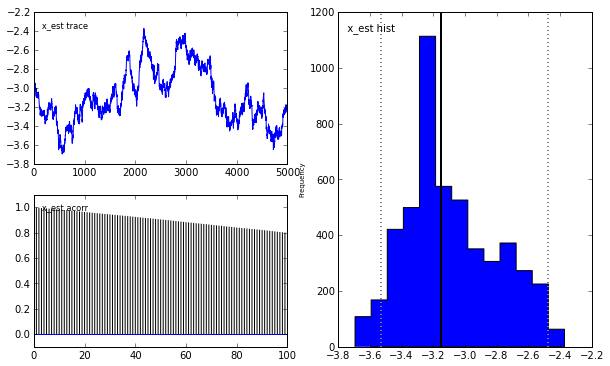

In [48]:
pm.Matplot.plot(Model.trace('x_est'))